# reel driver classifier analysis

## import dependancies

In [1]:
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns

## import data

In [2]:
media = pl.read_parquet("../data/media.parquet")
results = pl.read_parquet("../data/binomial_classifier_results.parquet")

display(media.head())
display(results.head())

hash,media_type,media_title,season,episode,release_year,pipeline_status,error_status,error_condition,rejection_status,rejection_reason,parent_path,target_path,original_title,original_path,original_link,rss_source,uploader,genre,language,rt_score,metascore,imdb_rating,imdb_votes,imdb_id,resolution,video_codec,upload_type,audio_codec,created_at,updated_at
str,cat,str,i64,i64,i64,cat,bool,str,cat,str,str,str,str,str,str,cat,str,list[str],list[str],i64,i64,f64,i64,str,str,str,str,str,datetime[μs],datetime[μs]
"""5c005007767abe4d870e3158a246f2…","""movie""","""Happy Howlidays""",null,null,2024,"""rejected""",false,null,"""rejected""","""resolution 720p is not in allo…",null,null,"""Happy Howlidays (2024) [720p] …",null,"""https://yts.mx/torrent/downloa…","""yts.mx""","""YTS.MX""","[""Romance""]","[""English""]",null,null,null,null,"""tt33908123""","""720p""",null,null,null,2024-12-21 20:47:03.408204,2025-01-16 17:28:57.023399
"""78174749714a6e869959a029f69187…","""movie""","""Kickboxer""",null,null,1989,"""rejected""",false,null,"""rejected""","""resolution 720p is not in allo…",null,null,"""Kickboxer (1989) [720p] [BluRa…",null,"""https://yts.mx/torrent/downloa…","""yts.mx""","""YTS.MX""","[""Action"", ""Sport"", ""Thriller""]","[""English""]",40,33,64.0,62544,"""tt0097659""","""720p""",null,null,null,2024-12-21 08:47:02.996516,2025-01-16 17:28:57.023399
"""875ba65c6cd12086173f7af6c45771…","""movie""","""A Cinderella Christmas Ball""",null,null,2024,"""rejected""",false,null,"""rejected""","""language is null""",null,null,"""A Cinderella Christmas Ball (2…",null,"""https://yts.mx/torrent/downloa…","""yts.mx""","""YTS.MX""",null,null,null,null,null,null,null,"""720p""",null,null,null,2024-12-23 23:47:03.549379,2025-01-16 17:28:57.023399
"""f0d71e7a14e0b9dd049c09d1da63bf…","""movie""","""Nothing Even Matters""",null,null,2024,"""rejected""",false,null,"""rejected""","""resolution 720p is not in allo…",null,null,"""Nothing Even Matters (2024) [7…",null,"""https://yts.mx/torrent/downloa…","""yts.mx""","""YTS.MX""","[""Action""]","[""English""]",null,null,null,null,"""tt32632860""","""720p""",null,null,null,2024-12-21 23:47:03.044457,2025-01-16 17:28:57.023399
"""806cb87ed442e6e911a8cb7eb801d9…","""movie""","""The Honey Trap""",null,null,2024,"""rejected""",false,null,"""rejected""","""language is null""",null,null,"""The Honey Trap (2024) [720p] […",null,"""https://yts.mx/torrent/downloa…","""yts.mx""","""YTS.MX""",null,null,null,null,null,null,null,"""720p""",null,null,null,2025-01-14 03:47:03.038302,2025-01-16 17:28:57.023399


actual,predicted,probability,hash
bool,i64,f32,str
false,0,0.036449,"""4ecdfbef265d31dae9d133f73bafdb…"
false,0,0.081126,"""d2ada20da14d56c50a13f790873024…"
true,1,0.998786,"""9269bd0e43e1fe6aeb38285cbc2b6a…"
false,0,0.000891,"""eccf72bbb9ce29fba3f655f0885691…"
false,0,0.005824,"""6ab2a6828287464f9e3ecaab907f4b…"


## format data for analysis

In [3]:
# join tables
df = results.join(media, on="hash", how="left")

# coerce predcited to boolean 
df = df.with_columns(pl.col("predicted").cast(pl.Boolean))

# create all confusion matrix fields
df = df.with_columns(
    cm_value = pl.when(pl.col("actual"))
        .then(
            pl.when(pl.col("predicted"))
                .then(pl.lit("TP"))
                .otherwise(pl.lit("FN"))
        ).otherwise(
            pl.when(pl.col("predicted"))
                .then(pl.lit("FP"))
                .otherwise(pl.lit("TN"))        
        )
)

# select only relevant fields
df = df.select(
    "media_title",
    "predicted",
    "actual",
    "cm_value",
    "probability",
    "release_year",
    "rt_score",
    "metascore",
    "imdb_rating",
    "imdb_votes",
    "original_title",
    "hash"
)

display(df.head())

# convert to pandas for compabiltiy 
pdf = df.to_pandas()

media_title,predicted,actual,cm_value,probability,release_year,rt_score,metascore,imdb_rating,imdb_votes,original_title,hash
str,bool,bool,str,f32,i64,i64,i64,f64,i64,str,str
"""Cavemen""",false,false,"""TN""",0.036449,2013,14,19,53.0,4550,"""Cavemen (2013) [1080p] [WEBRip…","""4ecdfbef265d31dae9d133f73bafdb…"
"""Pearl Jam Twenty""",false,false,"""TN""",0.081126,2011,68,59,82.0,8251,"""Pearl Jam Twenty (2011) [480p]…","""d2ada20da14d56c50a13f790873024…"
"""Shrek 2""",true,true,"""TP""",0.998786,2004,89,75,74.0,527363,"""Shrek 2 (2004) - Soundtrack [w…","""9269bd0e43e1fe6aeb38285cbc2b6a…"
"""The Sweet House of Horrors""",false,false,"""TN""",0.000891,1989,null,null,38.0,746,"""The Sweet House of Horrors (19…","""eccf72bbb9ce29fba3f655f0885691…"
"""Bloodline of the Jewel () [108…",false,false,"""TN""",0.005824,2025,null,null,null,null,"""Bloodline of the Jewel (2025) …","""6ab2a6828287464f9e3ecaab907f4b…"


## visualize results

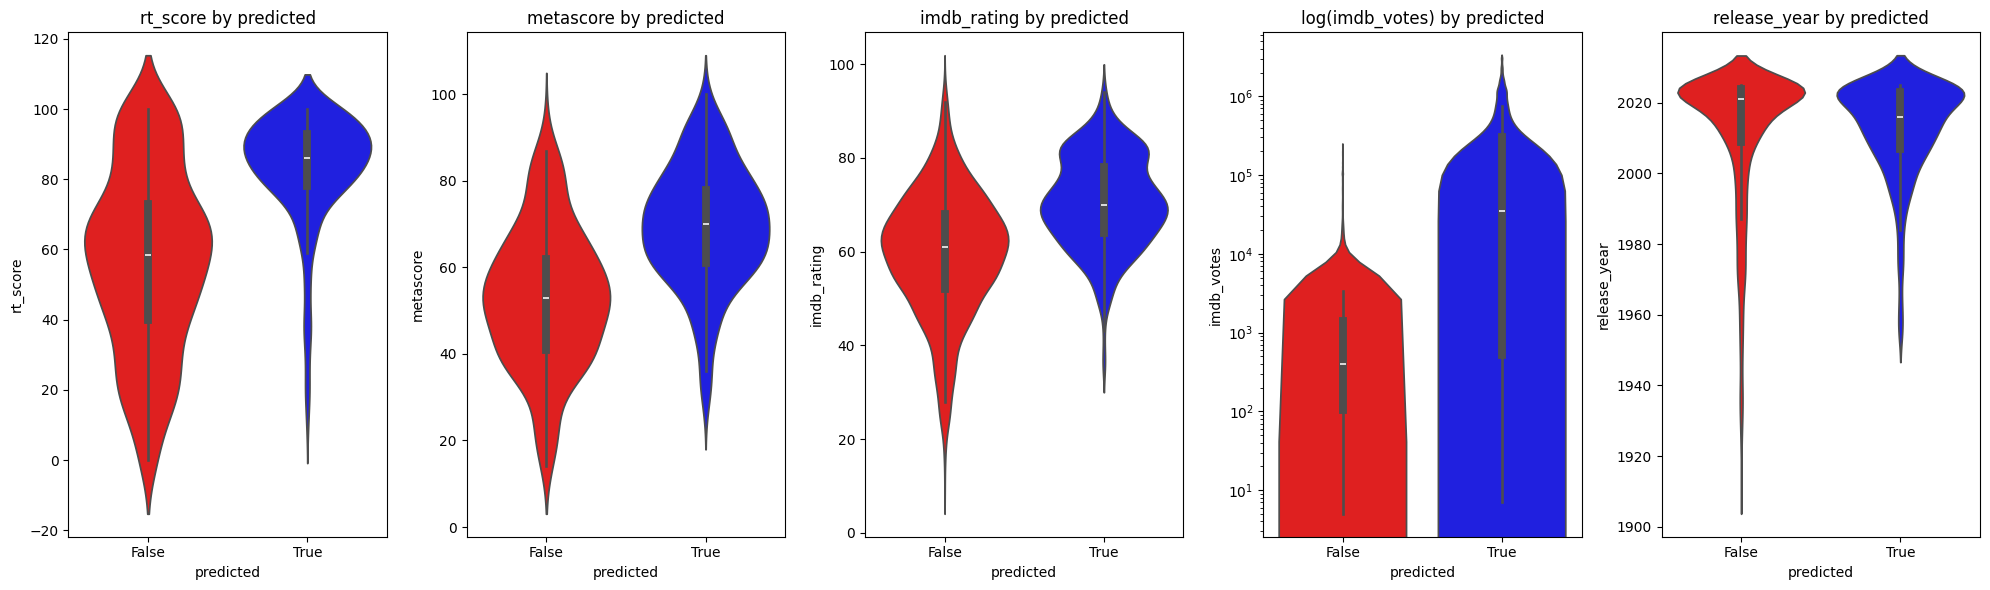

In [4]:
# distribution of numeric values by prediction label

# Create a figure with four subplots side by side
fig, axes = plt.subplots(1, 5, figsize=(20, 6))

# Define the colors for the classes
palette = {False: 'red', True: 'blue'}

# plot
sns.violinplot(x='predicted', y='rt_score', data=pdf, ax=axes[0], hue='predicted', palette=palette)
axes[0].set_title('rt_score by predicted')
axes[0].get_legend().remove()

sns.violinplot(x='predicted', y='metascore', data=pdf, ax=axes[1], hue='predicted', palette=palette)
axes[1].set_title('metascore by predicted')
axes[1].get_legend().remove()

sns.violinplot(x='predicted', y='imdb_rating', data=pdf, ax=axes[2], hue='predicted', palette=palette)
axes[2].set_title('imdb_rating by predicted')
axes[2].get_legend().remove()

sns.violinplot(x='predicted', y='imdb_votes', data=pdf, ax=axes[3], hue='predicted', palette=palette)
axes[3].set_title('log(imdb_votes) by predicted')
axes[3].get_legend().remove()
axes[3].set_yscale('log')

sns.violinplot(x='predicted', y='release_year', data=pdf, ax=axes[4], hue='predicted', palette=palette)
axes[4].set_title('release_year by predicted')
axes[4].get_legend().remove()


# Adjust layout
plt.tight_layout()
plt.show()

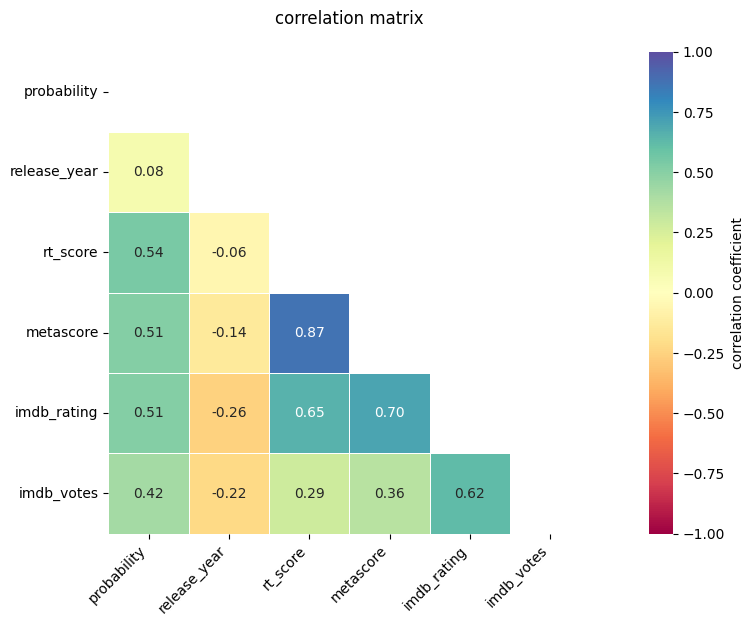

In [5]:
# correlation matrix
corr_df = df.select(
    "probability",
    "release_year",
    "rt_score",
    "metascore",
    "imdb_rating",
    "imdb_votes"
).drop_nulls()

corr_pdf = corr_df.to_pandas()

# Create correlation matrix
corr_matrix = corr_pdf.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Create heatmap
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,  # Show correlation values
    cmap='Spectral',  # Color scheme
    vmin=-1, vmax=1,  # Value range
    center=0,  # Center the colormap at 0
    square=True,  # Make the plot square-shaped
    fmt='.2f',  # Round correlation values to 2 decimal places
    linewidths=0.5,  # Width of the lines between cells
    cbar_kws={'label': 'correlation coefficient'}
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Add title
plt.title('correlation matrix', pad=20)

# Show the plot
plt.show()

In [6]:
# show outliers
# note: the conditional format will not render in github
false_negatives = df.filter(pl.col("cm_value")=="FN").sort("probability").to_pandas()

# Create styled table with conditional formatting
styled_false_negatives = (false_negatives
    .style
    .background_gradient(subset=['probability'], cmap='RdYlGn_r')  # Red to Yellow to Green (reversed)
    .bar(subset=['probability'], color='#4a90e2', align='mid')  # Add bar charts
    .format({'probability': '{:,.0f}', 'probability': '{:.2f}%'})  # Format numbers
    .set_caption('false positives')
)

display(styled_false_negatives)

false_positives = df.filter(pl.col("cm_value")=="FP").sort("probability", descending=True).to_pandas()

# Create styled table with conditional formatting
styled_false_positives = (false_positives
    .style
    .background_gradient(subset=['probability'], cmap='RdYlGn_r')  # Red to Yellow to Green (reversed)
    .bar(subset=['probability'], color='#4a90e2', align='mid')  # Add bar charts
    .format({'probability': '{:,.0f}', 'probability': '{:.2f}%'})  # Format numbers
    .set_caption('false negatives')
)

display(styled_false_positives)

,media_title,predicted,actual,cm_value,probability,release_year,rt_score,metascore,imdb_rating,imdb_votes,original_title,hash
0,Matthew Perry: A Hollywood Tragedy,False,True,FN,0.01%,2025,nan,nan,nan,nan,Matthew Perry: A Hollywood Tragedy (2025) [1080p] [WEBRip] [5.1] [YTS.MX],12ba50405d5d170f4c52f90e4c41ad9a8e3e1e89
1,Mickey 17 () [1080p] [WEBRip] [x265] [10bit] [5 1] [YTS MX],False,True,FN,0.01%,2025,nan,nan,nan,nan,Mickey 17 (2025) [1080p] [WEBRip] [x265] [10bit] [5.1] [YTS.MX],209f1161578d097d52df5084652b7e3e7ebe0beb
2,Modi: Three Days on the Wing of Madness,False,True,FN,0.01%,2024,nan,nan,nan,65.000000,Modi: Three Days on the Wing of Madness (2024) [720p] [BluRay] [YTS.MX],d2ee39b9ef8fa94778a8decf6317bfb78a65d005
3,Pyaar Ishq Aur Mohabbat,False,True,FN,0.01%,2001,nan,nan,42.000000,700.000000,Pyaar Ishq Aur Mohabbat (2001) [1080p] [WEBRip] [5.1] [YTS.MX],1cf57b5773bd1f0ef6d397b89b5e49d3eefa200d
4,Succubus,False,True,FN,0.01%,2024,nan,nan,46.000000,834.000000,Succubus (2024) [REPACK] [1080p] [WEBRip] [5.1] [YTS.MX],6a368789041c5185ef2b8c7afff540c6797e7dc4
5,Finding Me,False,True,FN,0.01%,2025,nan,nan,nan,nan,Finding Me (2025) [2160p] [WEBRip] [x265] [10bit] [5.1] [YTS.MX],33d27e3165f8f237f81d4ab393dcf8110e451ac0
6,The Twister: Caught in the Storm,False,True,FN,0.01%,2025,nan,nan,nan,nan,The Twister: Caught in the Storm (2025) [1080p] [WEBRip] [5.1] [YTS.MX],9ad8eafe3c6a6da613ec2acceaf93e41a7a6838b
7,The Magic School Bus Rides Again In The Zone,False,True,FN,0.01%,2020,nan,nan,60.000000,78.000000,The Magic School Bus Rides Again In The Zone (2020) [1080p] [WEBRip] [5.1] [YTS.MX],d31c466c349eb3b1869f19f03a5c2e45d721e60c
8,To End All War Oppenheimer The Atomic Bomb,False,True,FN,0.03%,2023,nan,nan,74.000000,2715.000000,To End All War Oppenheimer The Atomic Bomb (2023) [1080p] [WEBRip] [x265] [10bit] [5.1] [YTS.MX],5b3337d18375d7059eb33c5df1a3af45a2c8c277
9,The Magic School Bus Rides Again The Frizz Connection,False,True,FN,0.03%,2020,nan,nan,51.000000,57.000000,The Magic School Bus Rides Again The Frizz Connection (2020) [1080p] [WEBRip] [5.1] [YTS.MX],74cb5cb1c69138079ad5361898e5ea00a5a06d5c


,media_title,predicted,actual,cm_value,probability,release_year,rt_score,metascore,imdb_rating,imdb_votes,original_title,hash
0,Mickey 17,True,False,FP,0.98%,2025,78,75.000000,73.000000,2466,Mickey 17 (2025) [2160p] [WEBRip] [x265] [10bit] [5.1] [YTS.MX],60c90e4a9a6092ee3eb0e9c2b046269f6f49de1b
1,Galaxy Quest,True,False,FP,0.94%,1999,90,70.000000,74.000000,183116,Galaxy Quest (1999) [720p] [BluRay] [YTS.MX],bf71bbed16ea112c7b89e91f4e2a16347479c948
2,The Damned,True,False,FP,0.92%,2024,92,nan,60.000000,364,The Damned (2024) [2160p] [WEBRip] [x265] [10bit] [5.1] [YTS.MX],a173bc6b2bba9019b1e9723c6ec06cf344d9478b
3,The Actor,True,False,FP,0.84%,2025,78,61.000000,nan,9,The Actor (2025) [2160p] [WEBRip] [x265] [10bit] [5.1] [YTS.MX],822eb0871fc4d55e3b3795b905c4e6f0ab6a371d
4,My Fair Lady,True,False,FP,0.83%,1964,94,95.000000,77.000000,103904,My Fair Lady (1964) [2160p] [BluRay] [x265] [10bit] [5.1] [YTS.MX],d01f13a6b44be366ebbe5315f6da1ad250cf782e
5,Horror in the Forest,True,False,FP,0.78%,2023,100,nan,36.000000,381,Horror in the Forest (2023) [720p] [WEBRip] [YTS.MX],64542047192b8bd717697825f9b112df40ff82a7
6,Forest of Death,True,False,FP,0.78%,2023,100,nan,37.000000,377,Forest of Death (2023) [720p] [WEBRip] [YTS.MX],5f5fb35f370b9d071c391233c25fd3aa88e1351f
7,Eden,True,False,FP,0.75%,2014,84,81.000000,64.000000,5361,Eden (2014) [480p] [BluRay] [YTS.MX],6f90698195d4f9f2aaa554c51a479eadcd9e3c08
8,The Damned: Don't You Wish That We Were Dead,True,False,FP,0.72%,2015,100,nan,71.000000,475,The Damned: Don't You Wish That We Were Dead (2015) [720p] [BluRay] [YTS.MX],83334cf2e1d5c6a07b6030ed22c2275d98c1d6aa
9,Gladiator II,True,False,FP,0.66%,2024,71,64.000000,69.000000,112688,Gladiator II (2024) [1080p] [WEBRip] [5.1] [YTS.MX],fac9723b23484ebce62873f57f695599daf17d0c


In [7]:
# export false positives and false negaties for further investigation
false_positives = df.filter(pl.col('cm_value')=="FP").sort("probability")

with open("../data/false_positives.json", "w") as file:
    # Convert to records (list of dicts, each representing a row)
    records = [row for row in false_positives.iter_rows(named=True)]
    json.dump(records, file, indent=4)

false_negatives = df.filter(pl.col('cm_value')=="FN").sort("probability", descending=True)

with open("../data/false_negatives.json", "w") as file:
    # Convert to records (list of dicts, each representing a row)
    records = [row for row in false_negatives.iter_rows(named=True)]
    json.dump(records, file, indent=4)


### issues discoverd with training data

- parsing issue for some titles leading to issues with metadata collection
    - investigate parsing issues
- some items seems to have properly parsed values for media_title, but still have not succesfully collected metadata
    - re-run through OMDB API
